In [2]:
import os
import glob
from tqdm import tqdm
import zipfile
import functools
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K
import segmentation_models as sm
# import sys
# sys.path.append('.')

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import matplotlib.pyplot as plt
# import matplotlib as mpl
# mpl.rcParams['axes.grid'] = False
# mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [5]:
# This is needed to display the images.
%matplotlib inline

Evaluate on test set

52
data/testing/output/img-9b.png


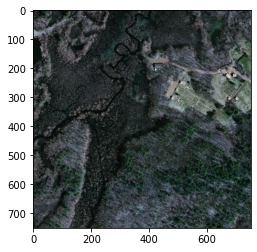

In [5]:
img_shape = (512, 512, 3)
batch_size = 4
n_classes = 1
BACKBONE = 'efficientnetb4'
img_dir = "data/testing/input/"
label_dir = "data/testing/output/"
x_val_filenames = glob.glob(img_dir + "/*.png")
y_val_filenames = glob.glob(label_dir + "/*.png")

print(len(x_val_filenames))
print(y_val_filenames[0])
plt.imshow(cv2.imread(x_val_filenames[0]))

In [6]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1):  # Randomly translate the image vertically
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=6,
                         batch_size=batch_size,
                         shuffle=False):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    # print(dataset)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    if shuffle:
        dataset = dataset.shuffle(num_x)

    # It's necessary to repeat our data for all epochs
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    # dataset = dataset.repeat().batch(batch_size)
    return dataset


def _process_pathnames(fname, label_path):
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_png(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_png(label_img_str)

    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    return img, label_img

In [7]:
val_cfg = {
    'resize': [512, 512],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)


val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames,
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

In [8]:
# LOSSES

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


# https://www.programmersought.com/article/60001511310/
def binary_focal_loss(gamma=2, alpha=0.25):
    """
    Binary form of focal loss.
         Focal loss for binary classification problems

    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)

        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (K.ones_like(y_true) - y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(focal_loss)

    return binary_focal_loss_fixed


model = sm.Unet(BACKBONE, classes=1, activation='sigmoid')
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(threshold=0.5),
          sm.metrics.Recall(threshold=0.5), dice_loss]

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=metrics)

# model.summary()

In [64]:
weights_path = 'swa_weights/model_swa_4.hdf5'
model.load_weights(weights_path)

In [65]:
from tensorflow.keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [66]:
def calculate_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    if np.sum(union) == 0:
        return None
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [67]:
def calculate_recall(target, prediction):
#   True positives
    tp = np.logical_and(target, prediction)
#   True positive plus false negatives, target or ground truth has all the pixels that should be part of bridge
    tp_fn = target 
    if np.sum(tp_fn) == 0:
        return None
    recall = np.sum(tp) / np.sum(tp_fn)
    return recall

In [68]:
def calculate_precision(target, prediction):
#   True positives
    tp = np.logical_and(target, prediction)
#   True positive plus false negatives, target or ground truth has all the pixels that should be part of bridge
    tp_fn = target 
    if np.sum(tp_fn) == 0:
        return None
    recall = np.sum(tp) / np.sum(tp_fn)
    return recall

In [69]:
def calculate_accuracy(target, prediction):
    all_pixels = (target.shape[0])**2
#   True positives
    tp = np.logical_and(target, prediction)
#   All white pixels/ Union   
    tp_fp_fn = np.logical_or(target, prediction)
#   True Negative
    tn = (all_pixels - np.sum(tp_fp_fn))     
    accuracy = (np.sum(tp) + tn)/all_pixels
    return accuracy

In [70]:
def calculate_dice_coeff(target, prediction):
    intersection = np.logical_and(target, prediction)
    dice_coeff = (2*np.sum(intersection)) / (np.sum(target) + np.sum(prediction))
    return dice_coeff

In [71]:
ds_iterator =val_ds.__iter__()
list_ious = []
list_recall = []
list_precision = []
list_dice_coeff = []
list_accuracy = []
for i in tqdm(range(13)):
    
    ds_next_element = next(ds_iterator)
    batch_of_imgs, label = ds_next_element[0].numpy(), ds_next_element[1].numpy()
    y_pred = model.predict(batch_of_imgs)
    for i in range(4):
        pred = np.reshape(y_pred[i], (512, 512))
        pred = np.where(pred > 0.5, 1, 0).astype('uint8')
        gt =   np.reshape(label[i], (512, 512))
        gt = np.where(gt > 0, 1, 0).astype('uint8')
        iou = calculate_iou(gt, pred)
        list_ious.append(iou)
        recall = calculate_recall(gt, pred)
        list_recall.append(recall)
        precision = calculate_precision(gt, pred)
        list_precision.append(precision)
        dice_coeff = calculate_dice_coeff(gt, pred)
        list_dice_coeff.append(dice_coeff)
        accuracy = calculate_accuracy(gt, pred)
        list_accuracy.append(accuracy)

100%|██████████| 13/13 [00:35<00:00,  2.74s/it]


In [72]:
print(len(list_ious))

52


In [73]:
list_ious_real_nos = []
for ious in list_ious:
    if ious is not None:
        list_ious_real_nos.append(ious)
mean_ious = np.sum(list_ious_real_nos)/len(list_ious_real_nos)
print('mean_iou: ', mean_ious)

mean_iou:  0.5996670817481672


In [74]:
list_precision_real_nos = []
for precision in list_precision:
    if precision is not None:
        list_precision_real_nos.append(precision)
mean_precision = np.sum(list_precision_real_nos)/len(list_precision_real_nos)
print('mean_precision: ', mean_precision)

mean_precision:  0.6690207012774896


In [77]:
list_recall_real_nos = []
for recall in list_recall:
    if recall is not None:
        list_recall_real_nos.append(recall)
mean_recall = np.sum(list_recall_real_nos)/len(list_recall_real_nos)
print('mean_recall: ', mean_recall)


mean_recall:  0.6690207012774896


In [78]:
list_accuracy_real_nos = []
for accuracy in list_accuracy:
    if accuracy is not None:
        list_accuracy_real_nos.append(accuracy)
mean_accuracy = np.sum(list_accuracy_real_nos)/len(list_accuracy_real_nos)
print('mean_accuracy: ', mean_accuracy)

mean_accuracy:  0.9641620929424579
